In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from brian2 import *
numpy.set_printoptions(threshold=numpy.nan)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from multiprocessing import *
from scipy.stats import norm,circstd,circmean
from scipy.signal import correlate2d
import time
import cProfile
from scipy.signal import fftconvolve

In [2]:
__all__ = ['generate_random_mcalpine_et_al_2001_bds']

def fixup(s):
    s = s.replace(',', '.')
    s = s.split('\n')
    s = [map(float, w.split('    ')) for w in s if w]
    f, bitd = zip(*s)
    f = array(f)*kHz
    bitd = array(bitd)*usecond
    return f, bitd

fig_2a_means = '''
0,09455    707,10712
0,16542    520,84442
0,23318    361,37778
0,29635    277,76535
0,35333    232,09654
0,41458    182,66420
0,46000    163,59335
0,51884    205,06943
0,57556    148,14299
0,61844    113,97392
0,68096    147,91190
0,75553    117,48437
0,80553    121,18188
0,99987    109,52809
'''

fig_2a_means_plus_stds = '''
0,09879    1125,42432
0,19757    819,93372
0,30073    604,84766
0,39557    412,23495
0,49462    412,60233
0,59540    333,41052
0,68949    242,79839
0,78939    307,37531
0,89622    250,80063
0,97863    201,73302
1,09955    209,49567
1,23526    228,61478
1,34885    179,54718
1,75320    191,33490
'''

_, mean_bitd = fixup(fig_2a_means)
f, bitd_mean_plus_std = fixup(fig_2a_means_plus_stds)
std_bitd = bitd_mean_plus_std-mean_bitd

def generate_random_mcalpine_et_al_2001_bds(cf,N,std_factor=1.0):
    fmid = 0.5*(f[1:]+f[:-1])
    I = digitize(cf, fmid)
    mu = mean_bitd[I]*2*cf[0]*180.0
    sigma = std_bitd[I]*std_factor*2*cf[0]*180.0
    x_axis = np.arange(-180, 180, 360.0/N)
    ##Creating the 2-sided BIPD distribution
    dist_bipd=exp(-(mu-x_axis)**2/(2*sigma**2))+ exp(-(-mu-x_axis)**2/(2*sigma**2))
    dist_bipd=dist_bipd/max(dist_bipd)
    dist_bipd_recentered=np.concatenate((dist_bipd[int(N/2):int(N)],dist_bipd[0:int(N/2)]))
    #plot(x_axis,dist_bipd_recentered)
    #show()
    return dist_bipd_recentered


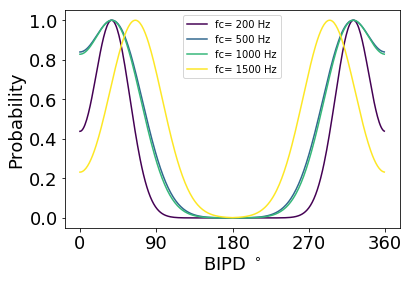

In [56]:
def BIPD_plots(arr_fc):
    cmap=plt.cm.viridis
    for i in xrange(len(arr_fc)):
        plt.gca().set_color_cycle([cmap(i) for i in np.linspace(0, 1, len(arr_fc))])
    dist_bipd=[]
    x_axis= np.arange(0, 360, 1)
    for i in xrange(len(arr_fc)):
        dist_bipd.append( generate_random_mcalpine_et_al_2001_bds([arr_fc[i]*Hz],360,std_factor=1.0))
    for i in xrange(len(arr_fc)):
        plot(x_axis,dist_bipd[i],label='fc= '+str(int(arr_fc[i]))+' Hz')
    xlabel('BIPD $^\circ$',fontsize=18)
    ylabel('Probability',fontsize=18)
    x=[0,90,180,270,360]
    xticks(x,x,fontsize=18)
    yticks(fontsize=18)
    #legend(bbox_to_anchor=[0.67,0.98],fontsize=10)
    legend()
arr_fc=[200,500,1000,1500]
BIPD_plots(arr_fc)

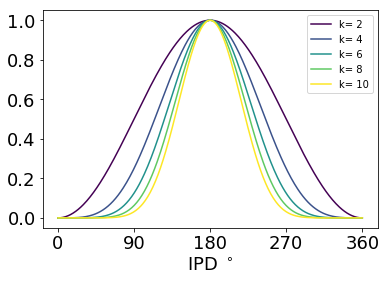

In [57]:
def tuning_curve(arr_k):
    cmap=plt.cm.viridis
    for i in xrange(len(arr_k)):
        plt.gca().set_color_cycle([cmap(i) for i in np.linspace(0, 1, len(arr_k))])
    for i in xrange(len(arr_k)):
        bipds=np.linspace(0,360,360)
        xlabel('IPD $^\circ$',fontsize=18)
     
        yticks(fontsize=18)
        plot(bipds,cos((pi-(bipds*pi/180.0))/2)**arr_k[i],label='k= '+str(arr_k[i]))
        x=[0,90,180,270,360]
        xticks(x,x,fontsize=18)
        xlabel('IPD $^\circ$',fontsize=18)
        yticks(fontsize=18)
        legend()
tuning_curve([2,4,6,8,10])

In [58]:
def canonical_dens_plots(tau,spread,stre_inh,kernel_func,sig_con,mcAlp_bipd,dphi_phase,Nx,Ny,fm,fc,m,ipd,tc,k,sigma,poisson_noise,dyn=False):
    fm=fm*Hz
    fc=fc*Hz
    tau=tau*ms
    fm_max=64*Hz
    n=int(1+np.ceil(3*tau*fm_max))

    if n%2==0:
        n+=1
    t = linspace(0, 1, n*Nx)*(1.0*n/fm)
    bipd = linspace(0, 2*n*pi, n*Ny, endpoint=False)%(2*pi)
    T, BIPD = meshgrid(t, bipd) 
    A = 0.5*(1-m*cos(2*pi*fm*T)) ##m   
    
    if dyn:
        PHI=(2*pi*fm*T+dphi_phase)%(2*pi)
    else:
        PHI =(ipd+dphi_phase)%(2*pi)
        
    if tc=='Cosine with exponent':
        TC=(cos((BIPD-PHI)/2))**k
    else:
        TC = (1.0/3)*(exp(-(BIPD-PHI)**2/(2*sigma**2))+
                   exp(-(BIPD-PHI+2*pi)**2/(2*sigma**2))+
                   exp(-(BIPD-PHI-2*pi)**2/(2*sigma**2)))
    
    layer1 = TC*A
    
    bipd_inf=int((Ny*n)*((n-1)/(2.0*n)))
    bipd_sup=int((Ny*n)*((n+1)/(2.0*n)))
    t_inf=int(Nx*n*(1-1.0/n))
    t_sup=int(Nx*n)
    
    if mcAlp_bipd:
        h_bipd=np.tile(generate_random_mcalpine_et_al_2001_bds([fc],Ny, std_factor=1.0),n)
        layer_weighted=layer1*h_bipd[...,np.newaxis]
    else:
        layer_weighted=layer1
     

    bipd_window = int(spread*(Ny))
    pix_t = (1.0/(Nx*fm))
    pix_bipd = 2*pi/(Ny)          
    ksize_t = int(3.*tau/pix_t)
        
    dt= arange(2*ksize_t+1)[::1]*pix_t 
    dbipd = arange(-bipd_window/2, bipd_window/2 +1)*pix_bipd
    DT, DBIPD = meshgrid(dt, dbipd)
    kernel0 = where(DT>ksize_t*pix_t, 0, exp(DT/tau))
    kernel0[:, kernel0.shape[1]/2] = 0

    if kernel_func=='Centrally weighted exp':
        for col in xrange(int(kernel0.shape[1]/2+1)):
            col_val=kernel0[0,col]
            for row in xrange(kernel0.shape[0]):
                kernel0[row,col]=col_val*exp(-0.001*abs(row-kernel0.shape[0]/2)**2/(2*sig_con**2))

    elif kernel_func=='Border weighted exp':
        for col in xrange(int(kernel0.shape[1]/2+1)):
            col_val=kernel0[0,col]
            for row in xrange(kernel0.shape[0]/2):
                kernel0[row+kernel0.shape[0]/2-2,col]=col_val*exp(-0.001*abs((kernel0.shape[0]-row)%(kernel0.shape[0]/2))**2/(2*sig_con**2))
                kernel0[row,col]=col_val*exp(-0.001*abs(row%(kernel0.shape[0]/2))**2/(2*sig_con**2))

    elif kernel_func=='Identity':
        kernel0=np.zeros(( dbipd.shape[0], dbipd.shape[0]))
        kernel0[int(dbipd.shape[0]/2),int(dbipd.shape[0]/2)]=1
    
    kernel0[dbipd.shape[0]/2,:]=0

    kernel=kernel0[::-1,::-1]
    kernel /= sum(kernel)
    inh_layer = fftconvolve(layer_weighted,kernel, mode='same')

    layer2= clip(layer_weighted-stre_inh*inh_layer,0, inf)        
    layer1=layer1[bipd_inf:bipd_sup,t_inf:t_sup]#,layer1[bipd_inf:bipd_sup,t_inf:t_sup]),1)
    layer_weighted=layer_weighted[bipd_inf:bipd_sup,t_inf:t_sup]#,layer_weighted[bipd_inf:bipd_sup,t_inf:t_sup]),1)
    layer_weighted_2=layer2[bipd_inf:bipd_sup,t_inf:t_sup]#,layer2[bipd_inf:bipd_sup,t_inf:t_sup]),1)
    inh_layer=inh_layer[bipd_inf:bipd_sup,t_inf:t_sup]#,inh_layer[bipd_inf:bipd_sup,t_inf:t_sup]),1)
    
    #if poisson_noise:
    #    layer_weighted_2/=np.amax(layer_weighted_2)
    #    layer_weighted_2=np.random.poisson(layer_weighted_2*100.0)
        
   
    return (layer1,layer_weighted_2,layer_weighted,kernel,inh_layer)

(100, 250)


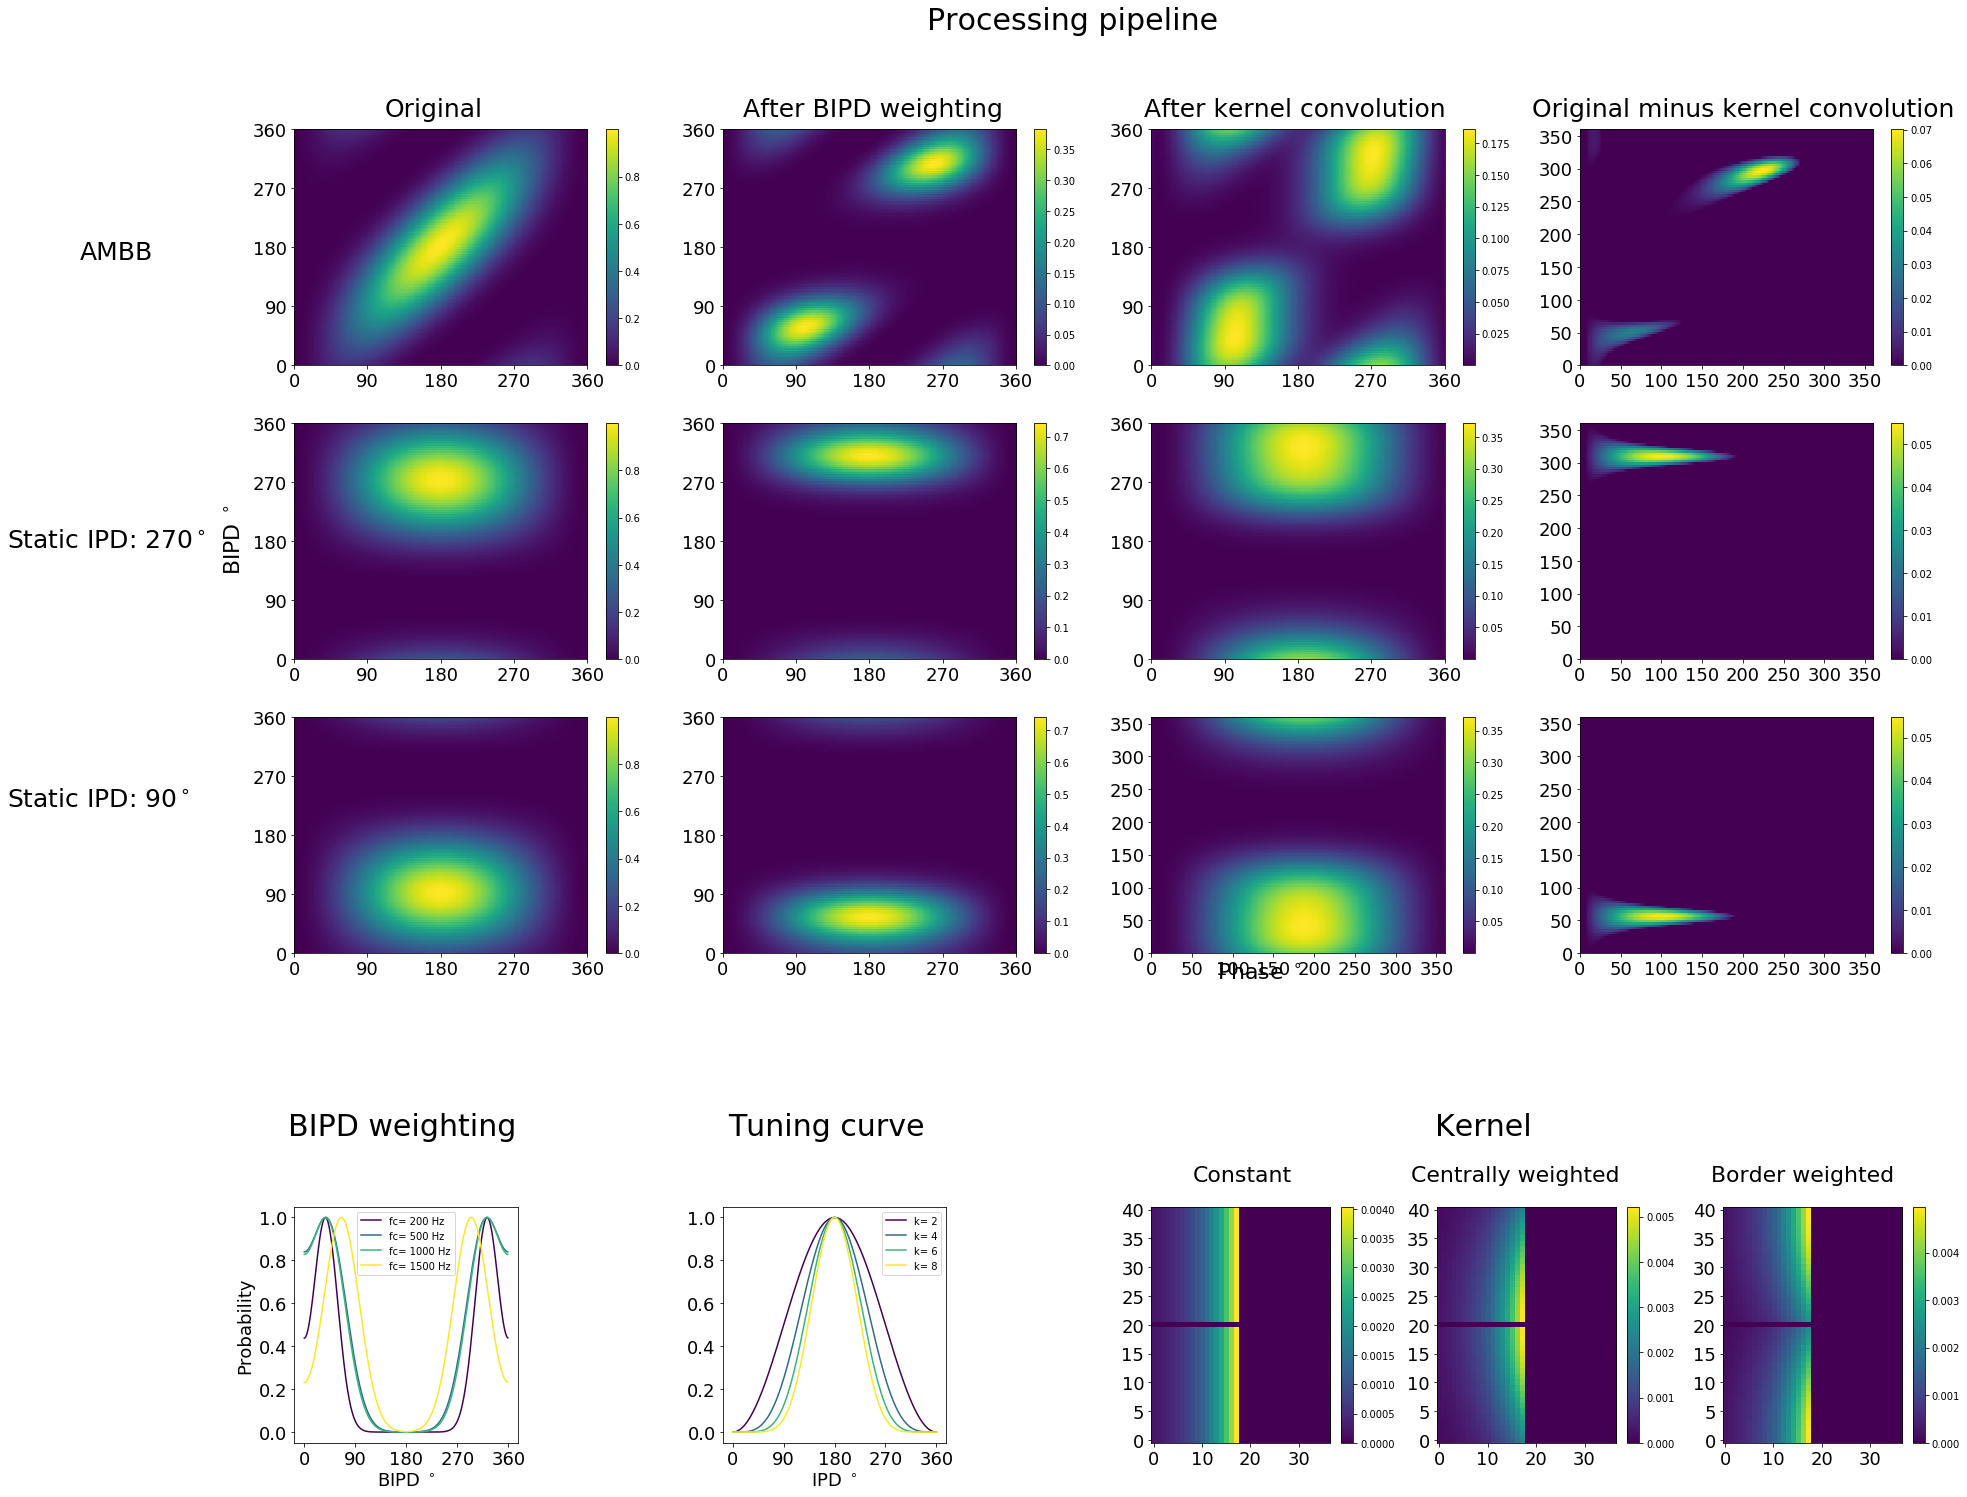

In [147]:
tau=6
spread=0.4
stre_inh=2
kernel_func='Constant'
sig_con=2
mcAlp_bipd=True
dphi_phase=0
Nx=250
Ny=100
fm=4
fc=500
m=1
ipd=0
tc='Cosine with exponent'
k=4
sigma=1
poisson_noise=False
dyn=True
num_training=20
ntrain90=int((num_training/4.0)*1)
ntrain270=int((num_training/4.0)*3)
ipds=np.linspace(0,2*pi,num_training,endpoint=False)
fig=figure(figsize=(30,20))   

gs = GridSpec(15, 15) 
layer1,layer_weighted_2,layer_weighted,kernel,inh_layer=canonical_dens_plots(tau,spread,stre_inh,kernel_func,sig_con,mcAlp_bipd,dphi_phase,Nx,Ny,fm,fc,m,ipd,tc,k,sigma,poisson_noise,dyn)
layer1_stat90,layer_weighted_2_stat90,layer_weighted_stat90,kernel_stat90,inh_layer_stat90=canonical_dens_plots(tau,spread,stre_inh,kernel_func,sig_con,mcAlp_bipd,dphi_phase,Nx,Ny,fm,fc,m,ipds[ntrain90],tc,k,sigma,poisson_noise,False)
layer1_stat270,layer_weighted_2_stat270,layer_weighted_stat270,kernel_stat270,inh_layer_stat270=canonical_dens_plots(tau,spread,stre_inh,kernel_func,sig_con,mcAlp_bipd,dphi_phase,Nx,Ny,fm,fc,m,ipds[ntrain270],tc,k,sigma,poisson_noise,False)
print layer1.shape
kernel_border=canonical_dens_plots(tau,spread,stre_inh,'Border weighted exp',0.5,mcAlp_bipd,dphi_phase,Nx,Ny,fm,fc,m,ipds[ntrain270],tc,k,sigma,poisson_noise,True)[3]
kernel_central=canonical_dens_plots(tau,spread,stre_inh,'Centrally weighted exp',0.5,mcAlp_bipd,dphi_phase,Nx,Ny,fm,fc,m,ipds[ntrain270],tc,k,sigma,poisson_noise,True)[3]
x=[0,90,180,270,360]
y=x
##First column
subplot(gs[0:3,0:3])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(layer1,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
xticks(x,x,fontsize=18)
yticks(y,y,fontsize=18)
colorbar()

subplot(gs[3:6,0:3])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(layer1_stat270,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
xticks(x,x,fontsize=18)
yticks(y,y,fontsize=18)
colorbar()

subplot(gs[6:9,0:3])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(layer1_stat90,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
colorbar()
xticks(x,x,fontsize=18)
yticks(y,y,fontsize=18)

##Second column
subplot(gs[0:3,3:6])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(layer_weighted,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
colorbar()
xticks(x,x,fontsize=18)
yticks(y,y,fontsize=18)

subplot(gs[3:6,3:6])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(layer_weighted_stat270,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
colorbar()
xticks(x,x,fontsize=18)
yticks(y,y,fontsize=18)


subplot(gs[6:9,3:6])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(layer_weighted_stat90,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
colorbar()
xticks(x,x,fontsize=18)
yticks(y,y,fontsize=18)

##Third column
subplot(gs[0:3,6:9])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(inh_layer,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
colorbar()
xticks(x,x,fontsize=18)
yticks(y,y,fontsize=18)

subplot(gs[3:6,6:9])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(inh_layer_stat270,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
colorbar()
xticks(x,x,fontsize=18)
yticks(y,y,fontsize=18)




subplot(gs[6:9,6:9])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(inh_layer_stat90,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
colorbar()
xticks(fontsize=18)
yticks(fontsize=18)

subplot(gs[0:3,9:12])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(layer_weighted_2,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
colorbar()
xticks(fontsize=18)
yticks(fontsize=18)

subplot(gs[3:6,9:12])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(layer_weighted_2_stat270,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
colorbar()
xticks(fontsize=18)
yticks(fontsize=18)

subplot(gs[6:9,9:12])
#title('Density plot, fm='+ str(fm)+' Hz before BIPD weighting')
imshow(layer_weighted_2_stat90,origin='lower left', interpolation='nearest', aspect='auto',extent=[0,360,0,360])
colorbar()
xticks(fontsize=18)
yticks(fontsize=18)


subplot(gs[11:14,0:2])
arr_fc=[200,500,1000,1500]
BIPD_plots(arr_fc)

subplot(gs[11:14,3:5])
arr_k=[2,4,6,8]
tuning_curve(arr_k)

subplot(gs[11:14,6:8])
imshow(kernel[::-1,::-1],origin='lower left', interpolation='nearest', aspect='auto')
xticks(fontsize=18)
yticks(fontsize=18)
colorbar()

subplot(gs[11:14,8:10])
imshow(kernel_central[::-1,::-1],origin='lower left', interpolation='nearest', aspect='auto')
xticks(fontsize=18)
yticks(fontsize=18)
colorbar()

subplot(gs[11:14,10:12])
imshow(kernel_border[::-1,::-1],origin='lower left', interpolation='nearest', aspect='auto')
xticks(fontsize=18)
yticks(fontsize=18)
colorbar()

text(-165,245,'Processing pipeline', fontsize=30)

text(-340, 205, 'AMBB',fontsize=25)
text(-355, 155, 'Static IPD: 270$^\circ$',fontsize=25)
text(-355, 110, 'Static IPD: 90$^\circ$',fontsize=25)
text(-277,230, 'Original',fontsize=25)
text(-203, 230, 'After BIPD weighting',fontsize=25)
text(-120, 230, 'After kernel convolution',fontsize=25)
text(-40, 230, 'Original minus kernel convolution',fontsize=25)
text(-105, 80, 'Phase $^\circ$ ',fontsize=22)
text(-310, 160,'BIPD $^\circ$', rotation=90,fontsize=22)
text(-297,53,'BIPD weighting', fontsize=30)
text(-206,53,'Tuning curve', fontsize=30)
text(-110,45,'Constant', fontsize=22)
text(-65,45,'Centrally weighted', fontsize=22)
text(-3,45,'Border weighted', fontsize=22)
text(-60,53,'Kernel', fontsize=30)


tight_layout()
savefig('figure_pop.pdf',bbox_inches='tight')